<a target="_blank" href="https://colab.research.google.com/github/RodrigoAVargasHdz/CHEM-4PB3/blob/w2024/Course_Notes/Week%206/TanimotoKernel.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
# !pip install gpytorch
# !pip install rdkit

In [2]:
import numpy as np
import pandas as pd
import torch
import gpytorch
from gpytorch.kernels import Kernel
from rdkit.Chem import AllChem, Descriptors, MolFromSmiles, MolToSmiles
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

from gpytorch.constraints import Positive
from torch import Tensor
import torch
from gpytorch.kernels import Kernel
from gpytorch.constraints import Positive

# Kernel for strings #

The kernel between two strings $\mathbf{x}$ and $\mathbf{x}'$ can be defined as,
$$
k(x,x') = \sum_{a\in{\cal A}^*}\omega_s \phi_s(\mathbf{x})\phi_s(\mathbf{x}'),
$$
where 
*  $\phi_s(\mathbf{x})$ denote the number of times that substring $s$ appears in string $\mathbf{x}$
* ${\cal A}$ is the alphabet of characters.
* $\omega_s$ is a non-negative weight for substring $s$
</br>
</br>

(**Example from Ref. [2](https://papers.nips.cc/paper/2000/file/68c694de94e6c110f42e587e8e48d852-Paper.pdf)**)\
![Arrays](https://raw.github.com/RodrigoAVargasHdz/CHEM-4PB3/master/Course_Notes/Figures/StringKernel.png)


</br>
</br>

**References**
1. [GP Book, Chapter 4, Section 4.4](https://gaussianprocess.org/gpml/chapters/) 
2. [(paper) Text classification with string kernels](https://papers.nips.cc/paper/2000/file/68c694de94e6c110f42e587e8e48d852-Paper.pdf)
3. [(paper) GAUCHE: A Library for Gaussian Processes in Chemistry](https://ml4physicalsciences.github.io/2022/files/NeurIPS_ML4PS_2022_75.pdf)
4. [(Wiki) String kernels](https://en.wikipedia.org/wiki/String_kernel)

# Kernels for molecules #
**Reference**: [paper](https://papers.nips.cc/paper/2000/file/68c694de94e6c110f42e587e8e48d852-Paper.pdf)

## Scalar product kernel ##
$k_{\text{Scalar Product}}(\mathbf{x},\mathbf{x}') = \ell \cdot \langle \mathbf{x},\mathbf{x}' \rangle$, \
where
* $\langle \mathbf{x},\mathbf{x}' \rangle$ is the  Euclidean inner product; $\langle \mathbf{x},\mathbf{x}' \rangle = \sum_i x_i x'_i$.
* $\ell$ is a scalar signal variance hyperparameter.
</br>
</br>


## Tanimoto kernel ##
General similarity metric for **binary attributes**, used in [Ref.](https://doi.org/10.1016/j.neunet.2005.07.009) for cheminformatics.

$k_{\text{Tanimoto}}(\mathbf{x},\mathbf{x}') = \ell \cdot \frac{\langle \mathbf{x},\mathbf{x}' \rangle}{\|\mathbf{x} \|^2 + \|\mathbf{x}'\|^2 - \langle \mathbf{x},\mathbf{x}' \rangle}$, \
where
* $\| \;\cdot\; \|$ is the Euclidian norm
* $\mathbf{x}$ is a binary vector, $x_i = \{0,1\}$
</br>
</br>


## Graph kernel ##
$k_{\text{Gprah}}(g,g') = \ell \cdot \langle \phi(g),\phi(g') \rangle_{{\cal H}}$,
where,
* $\langle \phi(g),\phi(g') \rangle_{{\cal H}}$  measures the similarity betweene two molecular graphs. Related to graph isomorphism. 
* $\ell$ is a scalar signal variance hyperparameter.

The graph kernel will be used this week [link](https://colab.research.google.com/github/RodrigoAVargasHdz/CHEM-4PB3/blob/main/Course_Notes/Week5/gpytorch_molecules.ipynb)



# Code

## Tanimoto kernel in Torch
Code is based on this [online tutorial](https://towardsdatascience.com/gaussian-process-regression-on-molecules-in-gpflow-ee6fedab2130), where $k_{\text{Tanimoto}}(\cdot,⋅)$ was coded in TensorFlow. \
For defining your own kernel in Gpytorch, one can follow the following [tutorial](https://docs.gpytorch.ai/en/stable/examples/00_Basic_Usage/Implementing_a_custom_Kernel.html).



In [3]:

# from ChatGPT 2023
# '''Write me a code compatible with GPyTorch for the Tanimoto kernel function'''
# '''remove the lengthscale parameter'''
class TanimotoKernel(gpytorch.kernels.Kernel):
    def __init__(self, active_dims=None):
        super(TanimotoKernel, self).__init__(active_dims=active_dims)
        self.register_parameter(
            name="raw_variance", parameter=torch.nn.Parameter(torch.ones(1))
        )
        self.register_constraint("raw_variance", gpytorch.constraints.Positive())

    @property
    def variance(self):
        return self.raw_variance_constraint.transform(self.raw_variance)

    @variance.setter
    def variance(self, value):
        self.raw_variance = self.raw_variance_constraint.inverse_transform(value)

    # def forward(self, x1, x2, **params):
    #     x1_ = x1.unsqueeze(-2)
    #     x2_ = x2.unsqueeze(-3)
    #     numerator = torch.sum(x1_ * x2_, dim=-1)
    #     denominator = torch.sum(x1_ + x2_ - x1_ * x2_, dim=-1)
    #     return self.variance * numerator / denominator

    def forward(self, x1, x2, **params):
        x1_ = x1.unsqueeze(-2)
        x2_ = x2.unsqueeze(-3)
        numerator = torch.sum(x1_ * x2_, dim=-1)
        denominator = torch.sum(x1_ ** 2, dim=-1) + \
            torch.sum(x2_ ** 2, dim=-1) - numerator
        return self.raw_variance * numerator / denominator  
    

    

In [4]:
n,d = 2, 5
x1 = torch.randint(0, 2, (n,d))
print('Random vectors')
print(x1)

Random vectors
tensor([[1, 1, 0, 0, 0],
        [0, 1, 1, 0, 1]])


In [5]:
print(x1.unsqueeze(-2).shape)
print(x1.unsqueeze(-2))
print(x1.unsqueeze(-3).shape)
print(x1.unsqueeze(-3))
print('*')

print(torch.sum(x1.unsqueeze(-2) * x1.unsqueeze(-3), dim=-1))
print(torch.tensordot(x1,x1, dims=([-1],[-1])))
print('*')

kernel = TanimotoKernel()
K = kernel.forward(x1,x1) ## is this correct?
print('Kernel matrix')
print(K)
print('Kernel parameter')
print(kernel.raw_variance)

torch.Size([2, 1, 5])
tensor([[[1, 1, 0, 0, 0]],

        [[0, 1, 1, 0, 1]]])
torch.Size([1, 2, 5])
tensor([[[1, 1, 0, 0, 0],
         [0, 1, 1, 0, 1]]])
*
tensor([[2, 1],
        [1, 3]])
tensor([[2, 1],
        [1, 3]])
*
Kernel matrix
tensor([[1.0000, 0.2500],
        [0.2500, 1.0000]], grad_fn=<DivBackward0>)
Kernel parameter
Parameter containing:
tensor([1.], requires_grad=True)


### GPT4 2024 ###

In [6]:
'''
class TanimotoKernel(Kernel):
    has_lengthscale = False

    def __init__(self, variance=None, **kwargs):
        super(TanimotoKernel, self).__init__(**kwargs)

        # Initialize the variance (outputscale) parameter
        if variance is None:
            self.raw_outputscale = torch.nn.Parameter(
                torch.log(torch.exp(torch.tensor(1.))-1))
        else:
            self.raw_outputscale = torch.nn.Parameter(torch.tensor(variance))

        self.register_constraint("raw_outputscale", Positive())

    @property
    def outputscale(self):
        return self.raw_outputscale_constraint.transform(self.raw_outputscale)

    @outputscale.setter
    def outputscale(self, value):
        self._set_outputscale(value)

    def forward(self, x1, x2, diag=False, **params):
        """
        Compute the scaled Tanimoto kernel between inputs x1 and x2.

        Args:
            x1 (Tensor): The first input tensor with shape (..., n, d) where n is the number of points
                         and d is the dimensionality of each point.
            x2 (Tensor): The second input tensor with shape (..., m, d) where m is the number of points
                         and d is the dimensionality of each point.
            diag (bool, optional): Whether to return the diagonal of the kernel matrix rather than the full
                                   kernel matrix. Defaults to False.

        Returns:
            Tensor: The computed kernel matrix scaled by the variance parameter.
        """
        prod = x1.matmul(x2.transpose(-2, -1))
        x1_sq = x1.pow(2).sum(dim=-1, keepdim=True)
        x2_sq = x2.pow(2).sum(dim=-1, keepdim=True).transpose(-2, -1)

        base = x1_sq + x2_sq - prod
        kernel_matrix = prod / base

        # Scale the kernel matrix by the variance parameter
        kernel_matrix *= self.outputscale

        if diag:
            return kernel_matrix.diag()
        else:
            return kernel_matrix
'''

'\nclass TanimotoKernel(Kernel):\n    has_lengthscale = False\n\n    def __init__(self, variance=None, **kwargs):\n        super(TanimotoKernel, self).__init__(**kwargs)\n\n        # Initialize the variance (outputscale) parameter\n        if variance is None:\n            self.raw_outputscale = torch.nn.Parameter(\n                torch.log(torch.exp(torch.tensor(1.))-1))\n        else:\n            self.raw_outputscale = torch.nn.Parameter(torch.tensor(variance))\n\n        self.register_constraint("raw_outputscale", Positive())\n\n    @property\n    def outputscale(self):\n        return self.raw_outputscale_constraint.transform(self.raw_outputscale)\n\n    @outputscale.setter\n    def outputscale(self, value):\n        self._set_outputscale(value)\n\n    def forward(self, x1, x2, diag=False, **params):\n        """\n        Compute the scaled Tanimoto kernel between inputs x1 and x2.\n\n        Args:\n            x1 (Tensor): The first input tensor with shape (..., n, d) where n is

# Example Caffeine

In [7]:
def get_fingerprints(m_smiles,radius=2):
  m = MolFromSmiles(m_smiles)
  m_fingerprints = AllChem.GetMorganFingerprintAsBitVect(m, radius=radius, nBits=2048)
  return np.asarray(m_fingerprints)

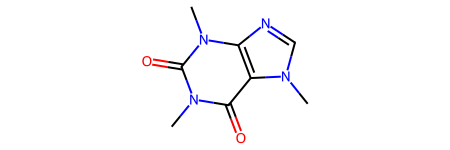

In [8]:
caff_sm = 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'
m = MolFromSmiles(caff_sm)
x_caff_fp = get_fingerprints(caff_sm)
m

Molecules similar to caffeine [link](https://www.acs.org/education/resources/highschool/chemmatters/past-issues/archive-2013-2014/caffeine.html)\
[Paraxanthine](https://en.wikipedia.org/wiki/Paraxanthine)

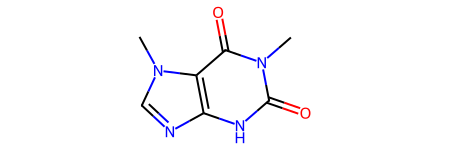

In [9]:
# Paraxanthine
parax_sm = 'O=C2Nc1ncn(c1C(=O)N2C)C'
m1 = MolFromSmiles(parax_sm)
x_parax_fp = get_fingerprints(parax_sm)
m1

Evaluate the Tanimoto kernel.

In [10]:
x_caff = torch.from_numpy(x_caff_fp).unsqueeze(0)
x_parax = torch.from_numpy(x_parax_fp).unsqueeze(0)
print('Tanimoto kernel for, Caffeine-Caffeine: ',kernel.forward(x_caff,x_caff))
print('Tanimoto kernel for, Caffeine-Paraxanthine: ',kernel.forward(x_caff,x_parax))
print('Tanimoto kernel for, Paraxanthine-Paraxanthine: ',kernel.forward(x_parax,x_parax))
print(kernel.raw_variance)

Tanimoto kernel for, Caffeine-Caffeine:  tensor([[1.]], grad_fn=<DivBackward0>)
Tanimoto kernel for, Caffeine-Paraxanthine:  tensor([[0.4857]], grad_fn=<DivBackward0>)
Tanimoto kernel for, Paraxanthine-Paraxanthine:  tensor([[1.]], grad_fn=<DivBackward0>)
Parameter containing:
tensor([1.], requires_grad=True)


# More data!!

In [11]:
data_url = "https://github.com/RodrigoAVargasHdz/CHEM-4PB3/raw/main/Course_Notes/data/solubility.csv"
data = pd.read_csv(data_url)
print(data.columns)

Index(['ID', 'Name', 'InChI', 'InChIKey', 'SMILES', 'Solubility', 'SD',
       'Ocurrences', 'Group', 'MolWt', 'MolLogP', 'MolMR', 'HeavyAtomCount',
       'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds',
       'NumValenceElectrons', 'NumAromaticRings', 'NumSaturatedRings',
       'NumAliphaticRings', 'RingCount', 'TPSA', 'LabuteASA', 'BalabanJ',
       'BertzCT'],
      dtype='object')


In [12]:
# print 10 molecules
print(data['SMILES'][:10])

0                  [Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C
1                                 O=C1Nc2cccc3cccc1c23
2                                      Clc1ccc(C=O)cc1
3    [Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...
4    C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...
5                                       Cc1cccc(C=C)c1
6                                  CCC1CCC(CCC(O)=O)C1
7    CC12CC(O)C3C(CCC4=CC(=O)C=CC34C)C1CC(O)C2(O)C(...
8                          Fc1ccc(cc1)C(=O)c2ccc(F)cc2
9                  O=C(OCCCOCCCOC(=O)c1ccccc1)c2ccccc2
Name: SMILES, dtype: object


In [13]:
# compute the FingerPrints for all molecules
X_fp = []
molecules = data['SMILES']#[:1000]
for m in molecules:
  x = get_fingerprints(m)
  X_fp.append(x)

[13:42:00] WARNING: not removing hydrogen atom without neighbors
[13:42:00] WARNING: not removing hydrogen atom without neighbors
[13:42:00] WARNING: not removing hydrogen atom without neighbors
[13:42:00] WARNING: not removing hydrogen atom without neighbors
[13:42:00] WARNING: not removing hydrogen atom without neighbors
[13:42:01] WARNING: not removing hydrogen atom without neighbors
[13:42:01] WARNING: not removing hydrogen atom without neighbors
[13:42:01] WARNING: not removing hydrogen atom without neighbors
[13:42:01] WARNING: not removing hydrogen atom without neighbors
[13:42:01] WARNING: not removing hydrogen atom without neighbors
[13:42:01] WARNING: not removing hydrogen atom without neighbors
[13:42:01] WARNING: not removing hydrogen atom without neighbors
[13:42:02] WARNING: not removing hydrogen atom without neighbors
[13:42:02] WARNING: not removing hydrogen atom without neighbors
[13:42:02] WARNING: not removing hydrogen atom without neighbors
[13:42:02] WARNING: not r

Text(0, 0.5, 'Counts')

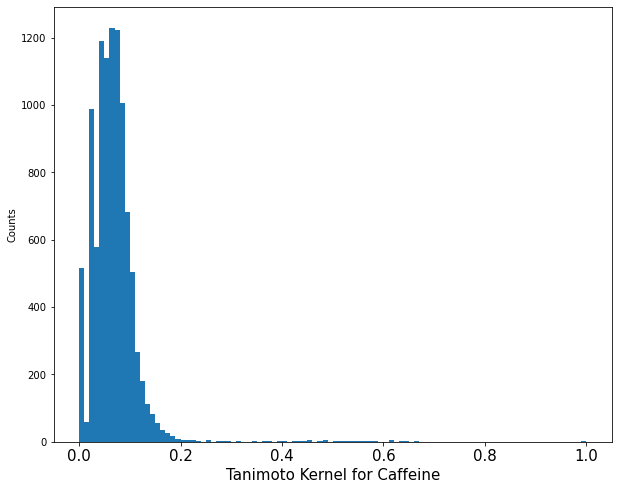

In [14]:
import matplotlib
import matplotlib.pyplot as plt


# # compute K(caffeine, molecule)
X_fp = torch.from_numpy(np.asarray(X_fp))
k_t = kernel.forward(x_caff,X_fp)
# print(k_t[:1000])

# from torch to numpy (don't forget!!)
k_values = k_t.detach().numpy()
k_values = k_values.flatten()
  
plt.figure(figsize=(10,8))
plt.hist(k_values, bins=100)
plt.xticks(fontsize=15)
plt.xlabel('Tanimoto Kernel for Caffeine',fontsize=15)
plt.ylabel('Counts')

C[N]1C=NC2=C1C(=O)N(C)C(=O)N2C
NO


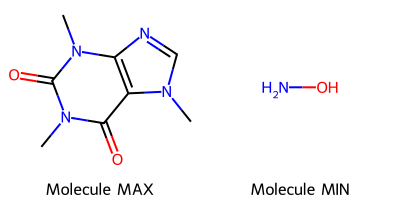

In [15]:
i_max = np.argmax(k_values)
smiles_max = data['SMILES'][i_max]
print(smiles_max)
i_min = np.argmin(k_values)
smiles_min = data['SMILES'][i_min]
print(smiles_min)

molecule1 = MolFromSmiles(smiles_max)
molecule2 = MolFromSmiles(smiles_min)

mols = [molecule1, molecule2]
img = Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(
    200, 200), legends=['Molecule MAX', 'Molecule MIN'])

img

In [16]:
def are_smiles_equal(smiles1, smiles2):
    # Convert the SMILES strings to RDKit molecule objects
    mol1 = MolFromSmiles(smiles1)
    mol2 = MolFromSmiles(smiles2)

    # Generate canonical SMILES for each molecule
    canonical_smiles1 = MolToSmiles(mol1)
    canonical_smiles2 = MolToSmiles(mol2)

    # Compare the canonical SMILES strings
    return canonical_smiles1 == canonical_smiles2

are_equal = are_smiles_equal(caff_sm, smiles_max)
print(f"Are the two SMILES equal? {are_equal}")

are_equal = are_smiles_equal(caff_sm, smiles_min)
print(f"Are the two SMILES equal? {are_equal}")

Are the two SMILES equal? True
Are the two SMILES equal? False


## Train a GP (GPyTorch)

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# data
# Xtot_np = k_values[:,np.newaxis]
Xtot_np = np.asarray(X_fp)
ytot_np = data['Solubility'].to_numpy()

scaler = StandardScaler()
scaler.fit(ytot_np[:,np.newaxis])
ytot_np = scaler.transform(ytot_np[:,np.newaxis])
ytot_np = ytot_np.ravel()

print(Xtot_np.shape,ytot_np.shape)

N = 800 #2500
Nval = 5000
X_train, X_test, y_train, y_test = train_test_split(Xtot_np, ytot_np, 
                                                    test_size=ytot_np.shape[0] - N, random_state=1)
if Nval > 0:
    X_test, y_test = X_test[:Nval], y_test[:Nval]
    Xtr, Xtst, ytr, ytst = X_train, X_test, y_train, y_test

if torch.cuda.is_available():
    Xtr = torch.from_numpy(Xtr).cuda()
    ytr = torch.from_numpy(ytr).float().cuda()
else:
    Xtr = torch.from_numpy(Xtr)
    ytr = torch.from_numpy(ytr).float()

Xtst = torch.from_numpy(Xtst).double()
ytst = torch.from_numpy(ytst).float()

Xtot = torch.from_numpy(Xtot_np)
ytot = torch.from_numpy(ytot_np)

(9982, 2048) (9982,)


In [18]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = TanimotoKernel()
        # self.covar_module = gpytorch.kernels.ScaleKernel(
        #     gpytorch.kernels.RBFKernel(ard_num_dims=train_x.shape[1]))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [19]:
# initialize likelihood and model

# likelihood = gpytorch.likelihoods.GaussianLikelihood().double()
# likelihood.noise = 1e-5  # Some small value, but don't make it too small or numerical performance will suffer. I recommend 1e-4.
# likelihood.noise_covar.raw_noise.requires_grad_(False)

likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-6)).double()
likelihood.noise = 1e-5 

model = ExactGPModel(Xtr, ytr, likelihood).double()

if torch.cuda.is_available():
    likelihood.cuda()
    model.cuda()

In [20]:
kernel = TanimotoKernel()
K = kernel.forward(Xtr,Xtr)
for i, k in enumerate(K):
  if not torch.any(torch.isnan(k)):
    print(i)
    print(Xtr[i])

0
tensor([0, 0, 0,  ..., 0, 0, 0])
1
tensor([0, 0, 0,  ..., 0, 0, 0])
2
tensor([0, 0, 0,  ..., 0, 0, 0])
3
tensor([0, 1, 0,  ..., 0, 0, 0])
4
tensor([0, 0, 0,  ..., 0, 0, 0])
5
tensor([0, 0, 0,  ..., 0, 0, 0])
6
tensor([0, 0, 0,  ..., 0, 0, 0])
7
tensor([0, 1, 0,  ..., 0, 0, 0])
8
tensor([0, 1, 0,  ..., 0, 0, 0])
9
tensor([0, 0, 0,  ..., 0, 0, 0])
10
tensor([0, 1, 0,  ..., 0, 0, 0])
11
tensor([0, 0, 0,  ..., 0, 0, 0])
12
tensor([0, 0, 0,  ..., 0, 0, 0])
13
tensor([0, 0, 0,  ..., 1, 0, 0])
14
tensor([0, 1, 0,  ..., 0, 0, 0])
15
tensor([0, 1, 0,  ..., 0, 0, 0])
16
tensor([0, 1, 0,  ..., 0, 0, 0])
17
tensor([0, 0, 0,  ..., 0, 0, 0])
18
tensor([0, 0, 0,  ..., 0, 0, 0])
19
tensor([0, 1, 0,  ..., 0, 0, 0])
20
tensor([0, 0, 0,  ..., 0, 0, 0])
21
tensor([0, 0, 0,  ..., 0, 0, 0])
22
tensor([0, 0, 0,  ..., 0, 0, 0])
23
tensor([0, 0, 0,  ..., 0, 0, 0])
24
tensor([0, 0, 0,  ..., 0, 0, 0])
25
tensor([0, 0, 0,  ..., 0, 0, 0])
26
tensor([0, 0, 0,  ..., 0, 0, 0])
27
tensor([0, 0, 0,  ..., 0, 0, 0])
28

In [21]:
# Find optimal model hyperparameters using ADAM

# Use the adam optimizer
# Includes GaussianLikelihood parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 250
mll_trajectory = []
mll_trajectory_tst = []
for i in range(training_iter+1):
    model.train()
    likelihood.train()
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(Xtr)
    # Calc loss and backprop gradients
    loss = -mll(output, ytr)
    loss.backward()
    mll_trajectory.append(loss.item())

    if (i % 25) == 0.:
      print('Iter %d/%d - Loss: %.5f  noise: %.6f' % (
          i, training_iter, loss.item(),
          model.likelihood.noise.item()
      ))
      print('sigma: ', model.covar_module.variance.item())
    optimizer.step()

Iter 0/250 - Loss: 97.47448  noise: 0.000010
sigma:  1.3132616875182228
Iter 25/250 - Loss: 14.39027  noise: 0.000072
sigma:  1.1409023833919498
Iter 50/250 - Loss: 6.20434  noise: 0.000186
sigma:  1.1249735355773303
Iter 75/250 - Loss: 4.22746  noise: 0.000301
sigma:  1.1303028195708789
Iter 100/250 - Loss: 3.31825  noise: 0.000420
sigma:  1.1316849664493718
Iter 125/250 - Loss: 2.77860  noise: 0.000550
sigma:  1.1320914891853178
Iter 150/250 - Loss: 2.42228  noise: 0.000691
sigma:  1.1317310605902888
Iter 175/250 - Loss: 2.17196  noise: 0.000843
sigma:  1.1314772994819327
Iter 200/250 - Loss: 1.98822  noise: 0.001006
sigma:  1.1311933668584728
Iter 225/250 - Loss: 1.84870  noise: 0.001178
sigma:  1.130904561819916
Iter 250/250 - Loss: 1.73987  noise: 0.001360
sigma:  1.13059815124043


## Prediction

In [22]:
# Prediction with GPyTorch
from torch.utils.data import TensorDataset, DataLoader

# 	In all other cases, he suggests using a power of 2 as the mini-batch size.
# 	So the minibatch should be 64, 128, 256, 512, or 1024 elements large.


dummy_test_y = torch.full_like(Xtst, dtype=torch.long, fill_value=0)
test_dataset = TensorDataset(Xtst, dummy_test_y)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

means = torch.tensor([0.])
stds = torch.tensor([[0.,0]])

model.eval()
likelihood.eval()
with torch.no_grad():
    for x_batch, _ in test_loader:
      if torch.cuda.is_available():
          xb = x_batch.cuda()
      else:
          xb = x_batch
      preds = likelihood(model(xb))
      mean = preds.mean.cpu()
      means = torch.cat([means, mean])

Text(0, 0.5, 'Data')

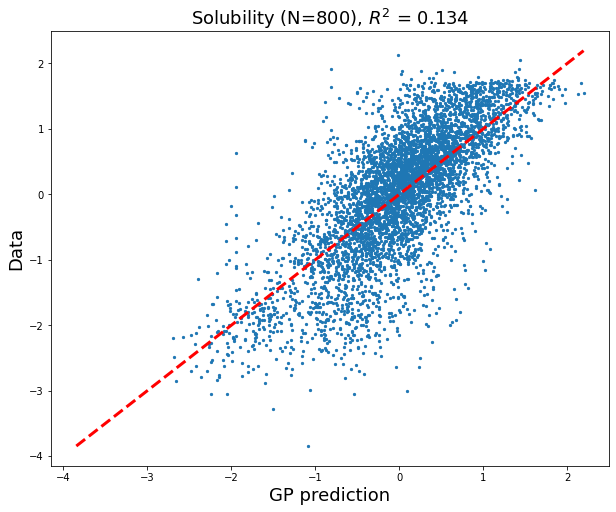

In [23]:
from sklearn.metrics import r2_score
import matplotlib
import matplotlib.pylab as plt

ytot_gp = means[1:].cpu().numpy() # torch to numpy 
ytst.cpu()
r2 = r2_score(ytot_gp,ytst.cpu())

plt.figure(figsize=(10,8))
plt.scatter(ytot_gp,ytst.cpu(),s=5)

low = np.min(np.stack((ytot_gp,ytst.cpu())).flatten())
high = np.max(np.stack((ytot_gp,ytst.cpu())).flatten())
plt.plot([low, high], [low, high], ls="--", c="red",lw=3.)

plt.title('Solubility (N=%s), $R^{2}$ = %.3f'%(N,r2),fontsize=18)
# plt.text(0.02,0.08,r'$R^{2}$ = %.3f'%r2,fontsize=18)
plt.xlabel('GP prediction',fontsize=18)
plt.ylabel('Data',fontsize=18)
# plt.show()
